This post will take a closer look at magnetic data collected by ocean drifters. The drifters were deployed off of the northwestern United States in the summer of 2012 by the Ocean Bottom Magenetology Laboratory. Five drifters collected data and reported back via an iridium link. The data is described in the following cell. 

More information about this project and data can be found at: http://deeptow.whoi.edu/research/magdrifter.html

The APS magnetic sensor made a measurement for 128 seconds every 20 minutes. Those 128 samples were averaged into one value of X,Y and Z magnetic field value. Every 4 hours the data were sent via Iridium to the Argo drifter database website

Once a day (every 24 hrs) a calibration cycle was run where 256 sequential raw data values were recorded. The data fields are ascii with an identifying first character to describe the type of data.

----------------------------------------------------

S: status line

S 000000000066760 123 270 2011.08.13 23:03:06 47.651360 -129.042221 8

S drifter_id rec_# day date time latitude longitude ?

----------------------------------------------------

M: measurement

M 1 -62475.9 -32540.4 -10721.9 19.39 47.9019 -128.9508 1.6 2011 224.80556 17.49

M meas_# xf yf zf temperature latitude longitude ? yr decimal_julian _day

----------------------------------------------------

E:

E 12.7 0

E battery_voltage ?

----------------------------------------------------

C: Calibration header

C 8 2011 225.12518

C id yr decimal_julian_day

c: calibration measurement

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
%matplotlib inline
import math
from datetime import datetime
from glob import glob
from datetime import timedelta
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap

In [9]:
#Convert julian day described in the data to datetime format
def convert_julian_frac(julian_frac, year):
    """
    julian_frac is string in the form of a float
    """
    frac, julian_day = math.modf(float(julian_frac)+1)
    #The drifters reported both 0 and 356 for julian days in the calendar year
    #When I get access to source code, I will try to determine which is correct
    if int(julian_day) > 365:
        julian_day = julian_day-365
        year = int(year) + 1
    mins, hrs = math.modf(frac*24.) 
    secs, mins = math.modf(mins*60)
    usecs, secs = math.modf(secs*60)
    dval= '%s %s %s %s %s' %(year, int(julian_day), int(hrs), int(mins), int(secs))
    dtval = datetime.strptime(dval, '%Y %j %H %M %S')
    return dtval

In [88]:
def load_data(fname):
    """Input the name of the drifter file downloaded from the website. This function parses the two types of data, 
    averaged measurements, M, and calibration measurements, C
    """
    dval = open(fname, 'r')
    mheaders = ["S_drifter_id", "S_record_num", "S_day", "S_date", "S_time", "S_lat", "S_lon", "S_?",
               "M_meas_num", "M_xf", "M_yf", "M_zf", "M_temp", "M_lat", "M_lon", "M_?", 
               "M_datetime", "battery_voltage"] 
    cheaders = [
                "C_id", "C_start_datetime","C_sample_datetime", 
                "c_num", "c_1", "c_2", "c_3", "c_4",
               ]
    mdata = []
    cdata = []
    #initialize batter voltage
    bvalue = -1
    
    for line in dval:
        line_vals = line.split(' ')
        line_vals = [x for x in line_vals if x!='']
        line_vals[-1] = line_vals[-1].strip()
        if line_vals[0] == 'S':
            #S drifter_id rec_num day date time latitude longitude ?
            mstatus = line_vals[1:]    
        if line_vals[0] == 'M':
            #M meas_num xf yf zf temperature latitude longitude ? yr decimal_julian _day
            mdt = convert_julian_frac(line_vals[10], line_vals[9])
            mval = mstatus + line_vals[1:9] + [mdt, bvalue]
            mdata.append(mval)   
        if line_vals[0] == 'C':
            #C id yr decimal_julian_day
            jdt = convert_julian_frac(line_vals[3], line_vals[2])
            Cid = line_vals[1]
            Cdf = jdt
        if line_vals[0] == 'c':
            #calibration measurement
            #Assuming 1Hz sample in calibration data (as described in final report)
            #so add 1 second to the C reported time for each sample
            cdata.append([Cid, Cdf, Cdf+timedelta(0,int(line_vals[1]))] + line_vals[1:])
        if line_vals[0] == 'E':
            #battery_voltage ?
            #Question: When is the voltage measured? - no timestamp
            bvalue = line_vals[1]

    mddict = {}
    mdatanp = np.asarray(mdata)
    for nn, name in enumerate(mheaders):
        mddict[name] = mdatanp[:,nn]
    mddpd = pd.DataFrame(mddict) 
    mddpd['M_datetime'] = mddpd['M_datetime'] 
    mddpd['S_date'] = pd.to_datetime(mddpd['S_date'])
    mddpd.index = mddpd['M_datetime']
    mddpd = mddpd.convert_objects(convert_numeric=True)
    #remove rows with invalid battery voltage
    mddpd = mddpd[mddpd['battery_voltage'] > 3]
    #remove bad latitude data
    mddpd = mddpd[mddpd['M_lat'] != -90.0]
    mddpd = mddpd[mddpd['M_lat'] != 0.0]
    mddpd = mddpd[mddpd.index > pd.to_datetime('2012-06-01 00:00:00')]
    cddict = {}
    cdatanp = np.asarray(cdata)
    for nn, name in enumerate(cheaders):
        cddict[name] = cdatanp[:,nn]
    cddpd = pd.DataFrame(cddict)
    cddpd['C_sample_datetime'] = pd.to_datetime(cddpd['C_sample_datetime'])
    cddpd.index = cddpd['C_sample_datetime']
    cddpd = cddpd.convert_objects(convert_numeric=True)
    return mddpd['2012-08-17':], cddpd['2012-08-17':]

#My raw files are located at data and are names as: drifter_<name>.txt
drifter_data_dir = '../../drifters/data'
drifter_files = glob(os.path.join(drifter_data_dir, 'drifter*.txt'))

#About the drifters
#Sneezy (66760: APS) apparently only lasted a month or so, perhaps hit by a ship.
#Bashful (68740 HMR) ended up near Glacier Bay in Alaska
#Grumpy (11070 HMR) reached Prince William Sound and was returned by mail to us 
#Dopey (68760 APS) traversed the inside channel of Vancouver Island and the Queen Charlotte’s.
#Sleepy (19370 APS) followed the coast of California and headed south across the eastern pacific.
drifter_dict = {
                'sneezy': {'maggie':{'type':'APS', 'id':66760}}, 
                'bashful':{'maggie':{'type':'HMR', 'id':68740}}, 
                'grumpy': {'maggie':{'type':'HMR', 'id':11070}}, 
                'dopey':  {'maggie':{'type':'APS', 'id':68760}}, 
                'sleepy': {'maggie':{'type':'APS', 'id':19370}}, 
                }

for df in drifter_files:
    dname = os.path.split(df)[1].replace('.txt', '')
    dname = dname.replace('drifter_', '')
    print("Loading %s and writing measured and calibration data files" %dname)
    measpd, calpd = load_data(df)
    mdname = df.replace('drifter_', 'measure_')
    measpd.to_csv(mdname, header=True, sep=' ', index=True)
    cdname = df.replace('drifter_', 'cal_')
    calpd.to_csv(cdname, header=True, sep=' ', index=True)
    drifter_dict[dname]['meas'] = measpd
    drifter_dict[dname]['cal'] = calpd 

Loading bashful and writing measured and calibration data files
Loading dopey and writing measured and calibration data files
Loading grumpy and writing measured and calibration data files
Loading sleepy and writing measured and calibration data files
Loading sneezy and writing measured and calibration data files


In [89]:
#normalize
for drifter in drifter_dict.keys():
    labelval = "%s - %s" %(drifter, drifter_dict[drifter]['maggie']['type'])
    #only plot data that we know is in the ocean (noisy up front)
    dd = drifter_dict[drifter]['meas']
    dd['norm_x'] = (dd['M_xf'] - dd['M_xf'].min())/(dd['M_xf'].max() - dd['M_xf'].min())
    dd['norm_battery_voltage'] = (dd['battery_voltage'] - dd['battery_voltage'].min())/(dd['battery_voltage'].max() - dd['battery_voltage'].min())

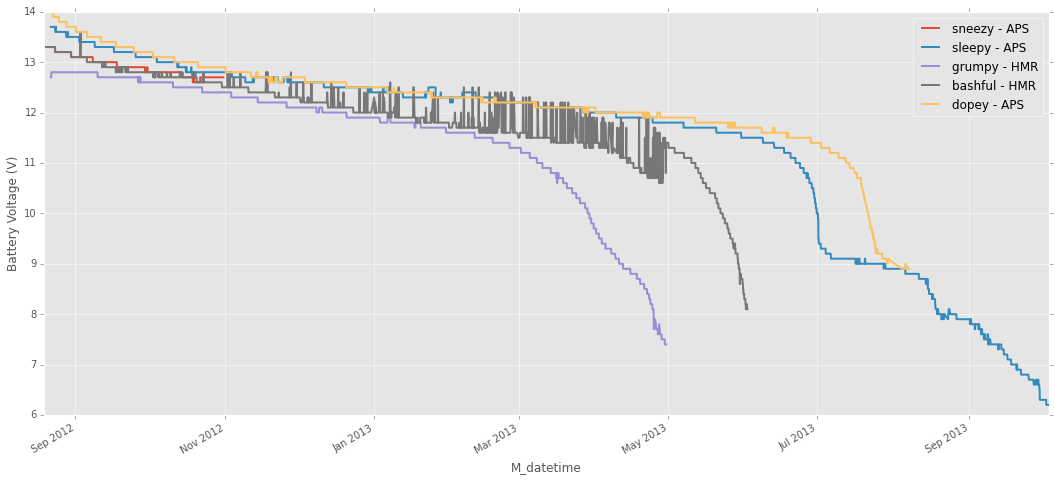

In [82]:
#plot battery voltage to determine when each drifter ran out of battery
plt.figure(figsize=(18,8))
plt.ylabel('Battery Voltage (V)')
for drifter in drifter_dict.keys():
    labelval = "%s - %s" %(drifter, drifter_dict[drifter]['maggie']['type'])
    drifter_dict[drifter]['meas']['battery_voltage'].plot(label=labelval, linewidth=2.0)
plt.legend()
#You can see that the two HMR sensors, grumpy and bashful, seemed to use the most power

In [12]:
#plot the tracks of the drifters
#first we need to determine the extents of the lat/lon
minlon, minlat = 999, 999
maxlon, maxlat = -999, -999
for drifter in drifter_dict.keys():
    minlond = drifter_dict[drifter]['meas']['M_lon'].min() 
    if minlond < minlon:
        minlon = minlond
    maxlond = drifter_dict[drifter]['meas']['M_lon'].max() 
    if maxlond > maxlon:
        maxlon = maxlond
    minlatd = drifter_dict[drifter]['meas']['M_lat'].min() 
    if minlatd < minlat:
        minlat = minlatd
    maxlatd = drifter_dict[drifter]['meas']['M_lat'].max() 
    if maxlatd > maxlat:
        maxlat = maxlatd
print("Extents:", minlat, maxlat, minlon, maxlon)
#build a map
m = Basemap(projection='merc', ellps='WGS84', 
           llcrnrlat=minlat, 
           urcrnrlat=maxlat,
           llcrnrlon=minlon,
           urcrnrlon=maxlon, 
           resolution='h')

('Extents:', 32.3433, 59.5633, -141.3018, -70.5402)


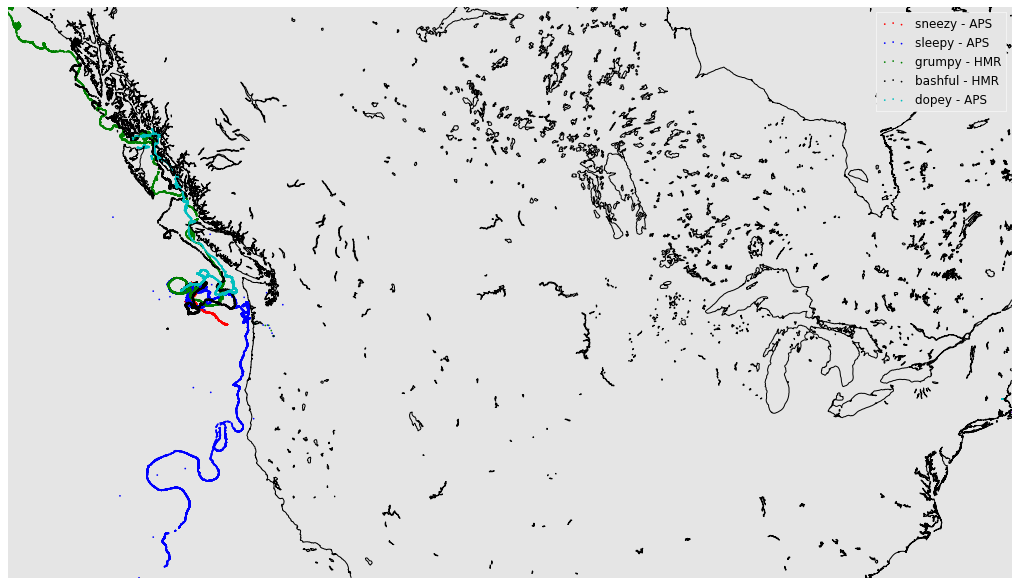

In [18]:
#plot map
plt.figure(figsize=(18,20))
colors = ['r', 'b', 'g', 'k', 'c']
for nn, drifter in enumerate(drifter_dict.keys()):
    dpd = drifter_dict[drifter]['meas']
    x, y = m(np.asarray(dpd['M_lon']), 
             np.asarray(dpd['M_lat']))
    labelval = "%s - %s" %(drifter, drifter_dict[drifter]['maggie']['type'])
    m.scatter(x, y, c=colors[nn], edgecolor="None", label=labelval, s=3)
m.drawcoastlines()
plt.legend()

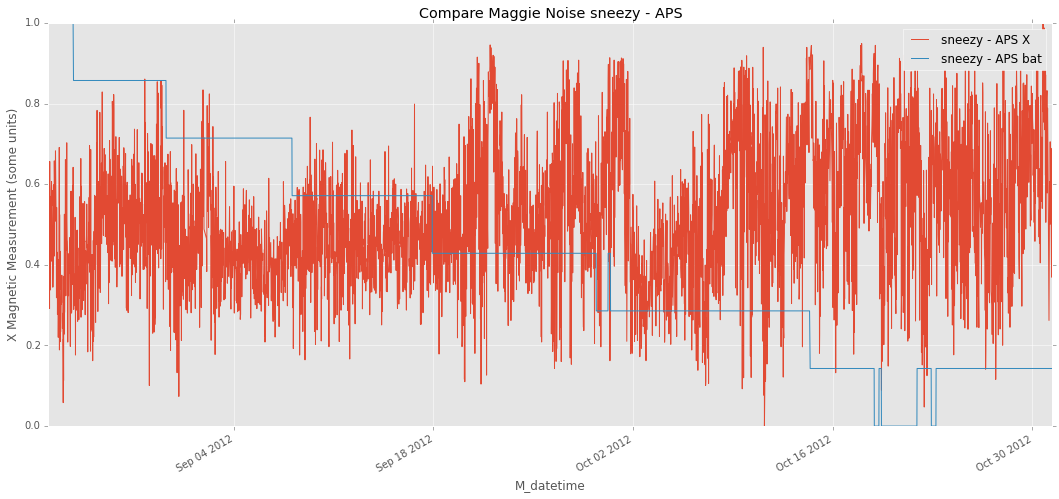

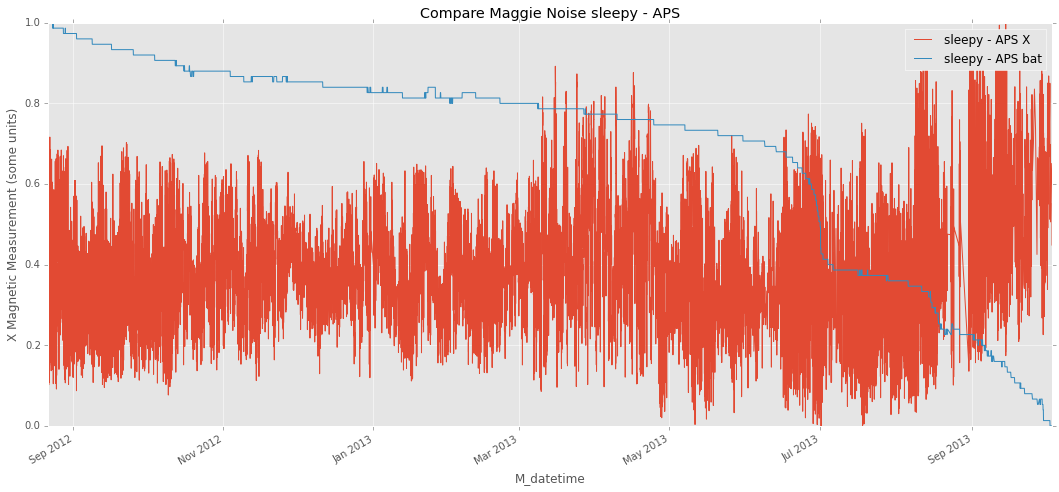

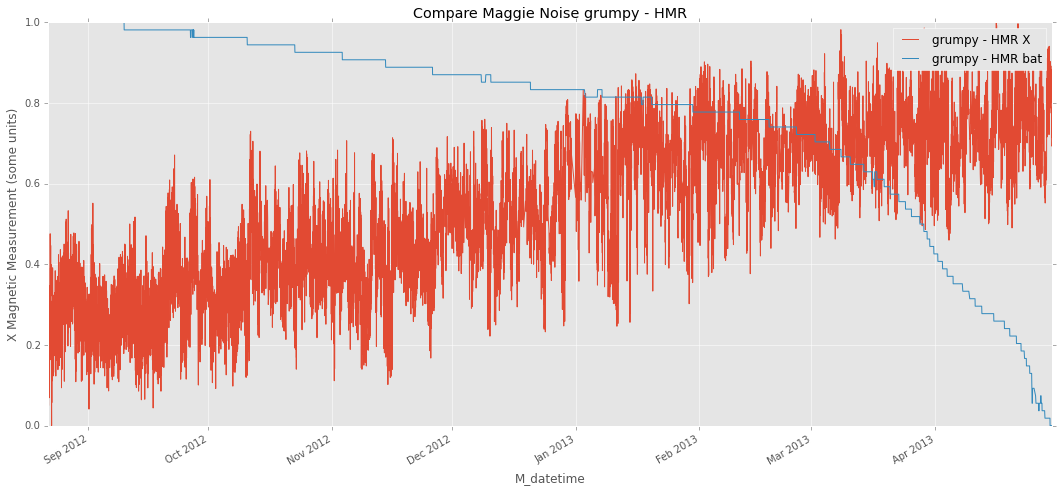

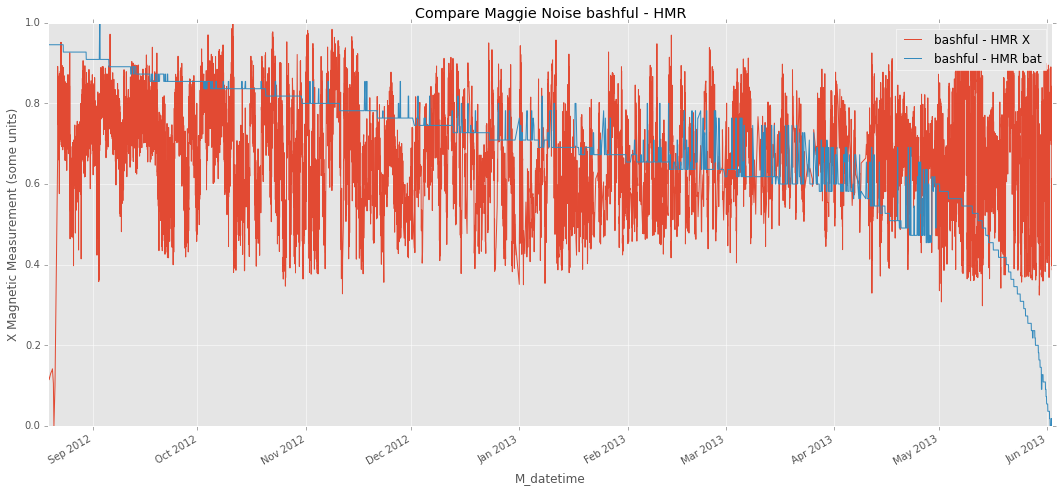

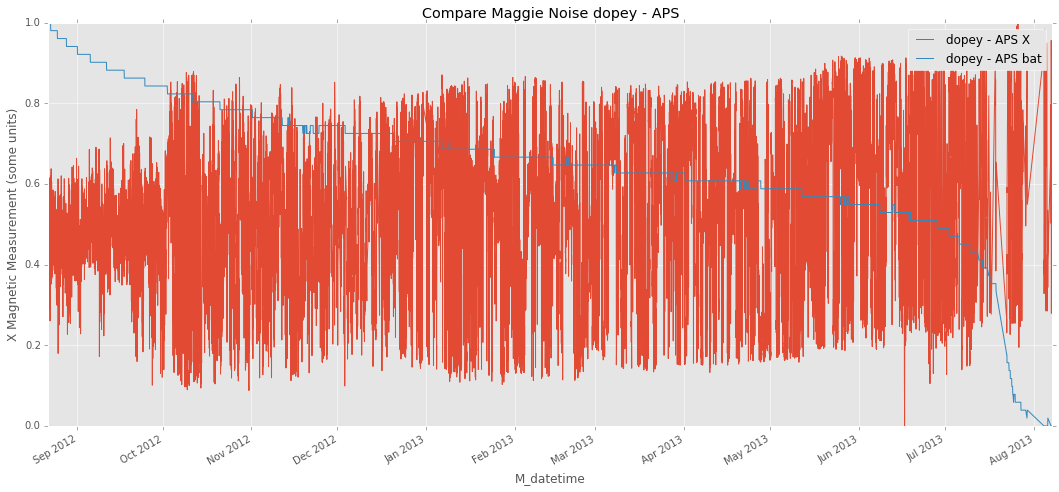

In [91]:
#plot maggie vals to compare determine noise

for drifter in drifter_dict.keys():
    plt.figure(figsize=(18,8))
    labelval = "%s - %s" %(drifter, drifter_dict[drifter]['maggie']['type'])
    plt.title("Compare Maggie Noise %s" %labelval)
    plt.ylabel('X Magnetic Measurement (some units)')
    #only plot data that we know is in the ocean (noisy up front)
    dd = drifter_dict[drifter]['meas']
    dd['norm_x'].plot(label=labelval + ' X')
    dd['norm_battery_voltage'].plot(label=labelval + ' bat')
    plt.legend()
#You can see that the two HMR sensors, grumpy and bashful, seemed to be much noiser

In [63]:
a = [10, 5, 2, 20]

#norm bt 0 and 20
[(x-min(a))/float(max(a)-min(a)) for x in a]

[0.4444444444444444, 0.16666666666666666, 0.0, 1.0]

2248.6 2248.6


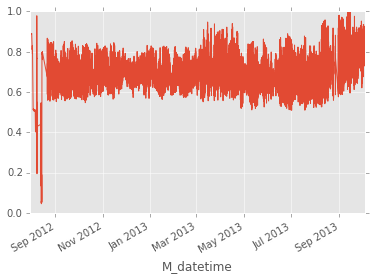

In [71]:
dd = drifter_dict['sleepy']['meas']

dd['norm_x'].plot()